# Transfer Learning for image data using CNN

# Unzip and load the dataset

In [1]:
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: data/
   creating: data/chicken-images/
   creating: data/chicken-images/test/
  inflating: data/chicken-images/test/0U5DJ4AHL7U8.jpg  
  inflating: data/chicken-images/test/0YRRH5UO983S.jpg  
  inflating: data/chicken-images/test/1O9LZD4GDLEG.jpg  
  inflating: data/chicken-images/test/1OX6JD87ZL6M.jpg  
  inflating: data/chicken-images/test/1ZLB7IELNMCD.jpg  
  inflating: data/chicken-images/test/2IH2F7SXSTFS.jpg  
  inflating: data/chicken-images/test/2MD30734HGEK.jpg  
  inflating: data/chicken-images/test/37ROYA9ANCBW.jpg  
  inflating: data/chicken-images/test/3PAKQG6U95KF.jpg  
  inflating: data/chicken-images/test/4DN8EXU7DK8L.jpg  
  inflating: data/chicken-images/test/58O558O7Z1EE.jpg  
  inflating: data/chicken-images/test/5QGOZ68RTPD5.jpg  
  inflating: data/chicken-images/test/5S2Z8N8RHE3T.jpg  
  inflating: data/chicken-images/test/6Q16NMCZX1GA.jpg  
  inflating: data/chicken-images/test/7BO7XC21FY83.jpg  
  inflating: data/chicken

# Import necessary libraries

In [2]:
import os, sys, random, time, copy, glob

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms

from sklearn.metrics import classification_report

from PIL import Image

import warnings

from tempfile import TemporaryDirectory

# Set up the data for training

## Path to Chicken and Duck Images

In [3]:
CHICKEN_IMAGES_PATH = "/content/data/chicken-images/"
DUCK_IMAGES_PATH = "/content/data/duck-images/"

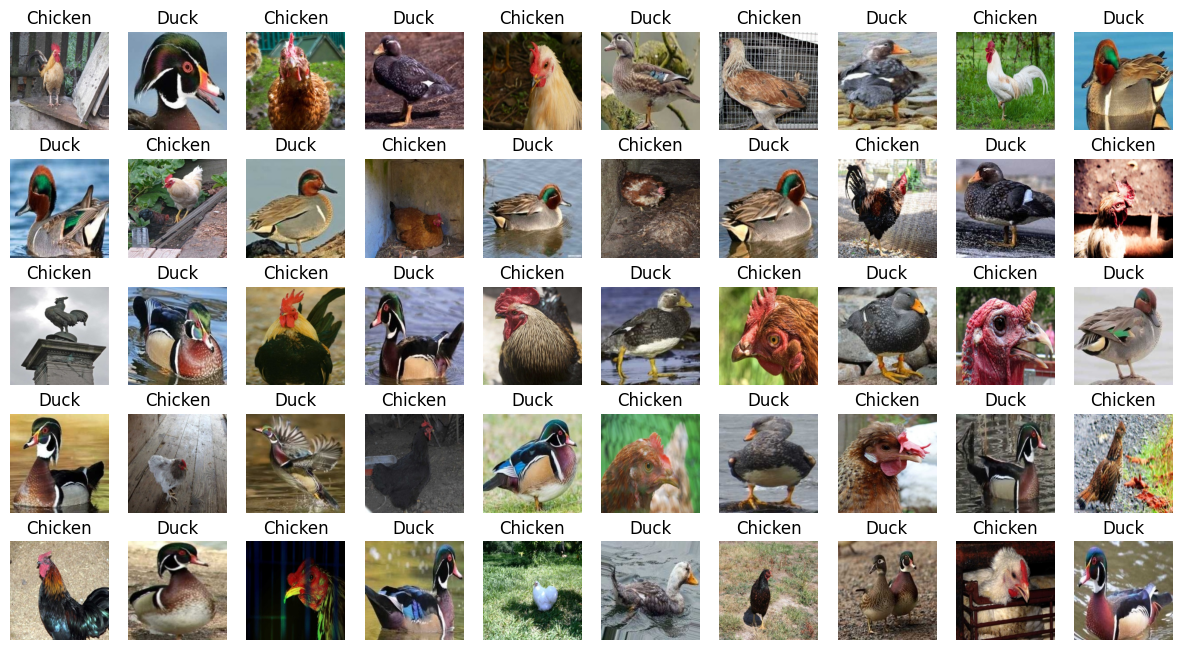

In [4]:
chicken_images_dir = glob.glob(f"{CHICKEN_IMAGES_PATH}/train/*")
duck_images_dir = glob.glob(f"{DUCK_IMAGES_PATH}/train/*")

# set random seed for reproducibility
random.seed(9)

# see 25 images each of chicken and duck
chicken = random.sample(chicken_images_dir, k = 25)
duck = random.sample(duck_images_dir, k = 25)

fig, ax = plt.subplots(5, 10, figsize=(15, 8))
for i in range(5):
  for j in range(10):
    if (i+j)%2 == 0:
      ax[i,j].imshow(Image.open(chicken[0]))
      chicken.pop(0)
      ax[i,j].axis("off")
      ax[i,j].set_title("Chicken")
    else:
      ax[i,j].imshow(Image.open(duck[0]))
      duck.pop(0)
      ax[i,j].axis("off")
      ax[i,j].set_title("Duck")
plt.show()

## Create annotations

In [5]:
def create_annotations_file(paths: list[str]):
    # training dataset
    train = pd.DataFrame(columns=["path", "class"])
    for path in paths:
        full_path = os.path.join(path, "train")
        image_names = [f"{path}/train/{_}" for _ in os.listdir(full_path)]
        label = path.split("/")[3]
        temp = pd.DataFrame({"path": image_names, "class": label})
        train = pd.concat([train, temp])

    # validation dataset
    val = pd.DataFrame(columns=["path", "class"])
    for path in paths:
        full_path = os.path.join(path, "val")
        image_names = [f"{path}/val/{_}" for _ in os.listdir(full_path)]
        label = path.split("/")[3]
        temp = pd.DataFrame({"path": image_names, "class": label})
        val = pd.concat([val, temp])

    # test dataset
    test = pd.DataFrame(columns=["path", "class"])
    for path in paths:
        full_path = os.path.join(path, "test")
        image_names = [f"{path}/test/{_}" for _ in os.listdir(full_path)]
        label = path.split("/")[3]
        temp = pd.DataFrame({"path": image_names, "class": label})
        test = pd.concat([test, temp])

    train = train.reset_index(drop=True)
    val = val.reset_index(drop=True)
    test = test.reset_index(drop=True)

    return train, val, test


## Get the training, validation and test data

In [6]:
train, val, test = create_annotations_file([CHICKEN_IMAGES_PATH, DUCK_IMAGES_PATH])

### Check class distribution in the data

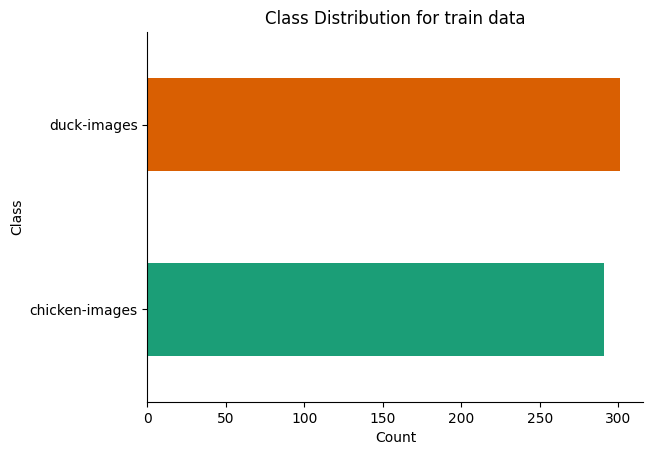

In [7]:
train.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Class Distribution for train data')
plt.xlabel('Count')
plt.ylabel('Class')
plt.gca().spines[['top', 'right',]].set_visible(False)

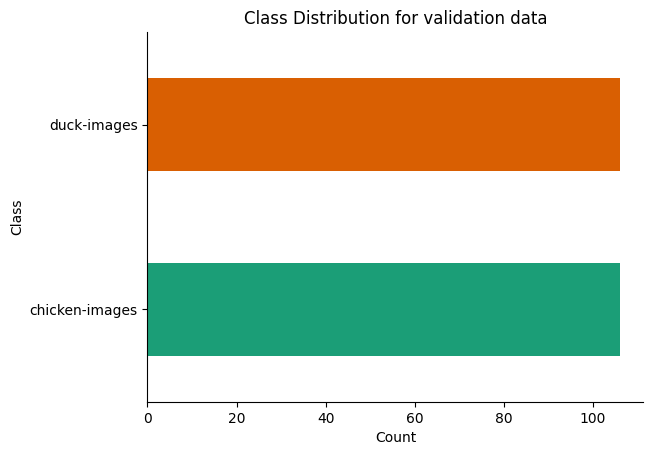

In [8]:
val.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Class Distribution for validation data')
plt.xlabel('Count')
plt.ylabel('Class')
plt.gca().spines[['top', 'right',]].set_visible(False)

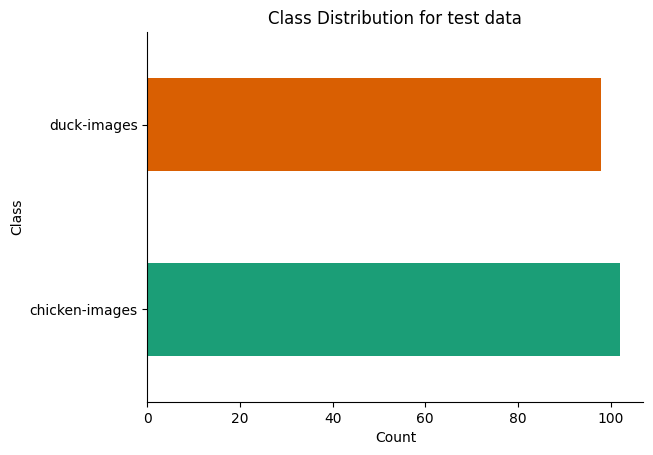

In [9]:
test.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Class Distribution for test data')
plt.xlabel('Count')
plt.ylabel('Class')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [10]:
class ChickenOrDuck(Dataset):

    def __init__(
        self, annotations_file, transforms=transforms.Compose([transforms.ToTensor()])
    ):
        super().__init__()
        self.annotations_file = annotations_file
        self.transforms = transforms

    def __getitem__(self, index):
        image_path = self.annotations_file.loc[index, "path"]
        image_class = self.annotations_file.loc[index, "class"]
        image_label = 1 if image_class == "chicken-images" else 0

        image = Image.open(image_path).convert("RGB")
        image = image.resize((256, 256))
        image = self.transforms(image)

        return image, image_label

    def __len__(self):
        return len(self.annotations_file)

## Preprocess the data

In [11]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # Image Net mean and std

image_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ]
    ),
}


## Load the datasets

In [12]:
train_dataset = ChickenOrDuck(train, image_transforms["train"])
val_dataset = ChickenOrDuck(val, image_transforms["val"])
test_dataset = ChickenOrDuck(test, image_transforms["val"])

## Set up device and Batch size

In [13]:
BATCH_SIZE = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
print(device)

cuda


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Number of Batches and Total number of images

Number of batches

In [16]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(37, 14, 13)

Number of images in train, val and test data

In [17]:
val_size = len(val_dataset)
train_size = len(train_dataset)
test_size = len(test_dataset)

In [18]:
train_size, val_size, test_size

(592, 212, 200)

# Function for training the model

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 50)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode

                    running_loss = 0.0
                    running_corrects = 0

                    for inputs, labels in train_dataloader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward
                        # track history if only in train
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                            loss.backward()
                            optimizer.step()

                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
                        scheduler.step()

                    epoch_loss = running_loss / train_size
                    epoch_acc = float(running_corrects) / train_size

                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                else:
                    model.eval()   # Set model to evaluate mode

                    running_loss = 0.0
                    running_corrects = 0

                    # Iterate over data.
                    for inputs, labels in val_dataloader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward
                        # track history if only in train
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
                        scheduler.step()


                    epoch_loss = running_loss / val_size
                    epoch_acc = float(running_corrects) / val_size

                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                    # deep copy the model
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(50*"-")
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        print(50*"-")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

# Load the pretrained model - Resnet18

## Adjust the final layer and set up loss function and optimizer

In [20]:
model_ft = resnet18(weights = ResNet18_Weights)

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.9MB/s]


## Fit the model

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 1/15
--------------------------------------------------
train Loss: 0.4427 Acc: 0.8530
val Loss: 0.4031 Acc: 0.8821
Epoch 2/15
--------------------------------------------------
train Loss: 0.4244 Acc: 0.8767
val Loss: 0.4002 Acc: 0.8774
Epoch 3/15
--------------------------------------------------
train Loss: 0.4197 Acc: 0.8666
val Loss: 0.4025 Acc: 0.8774
Epoch 4/15
--------------------------------------------------
train Loss: 0.4152 Acc: 0.8699
val Loss: 0.4003 Acc: 0.8821
Epoch 5/15
--------------------------------------------------
train Loss: 0.4153 Acc: 0.8885
val Loss: 0.4035 Acc: 0.8774
Epoch 6/15
--------------------------------------------------
train Loss: 0.4219 Acc: 0.8750
val Loss: 0.4005 Acc: 0.8774
Epoch 7/15
--------------------------------------------------
train Loss: 0.4134 Acc: 0.8750
val Loss: 0.4033 Acc: 0.8774
Epoch 8/15
--------------------------------------------------
train Loss: 0.4158 Acc: 0.8716
val Loss: 0.4002 Acc: 0.8821
Epoch 9/15
-------------

# Classification Report

In [22]:
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

In [23]:
# Get predictions for the test set
predictions, true_labels = get_predictions(model_ft, test_dataloader, device)

# Generate the classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92        98
           1       0.98      0.85      0.91       102

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200



Here `Chicken = 1` and `Duck = 0`